<a href="https://colab.research.google.com/github/KevinLeo360/LearningPYTHON/blob/main/Apriori_Algorithm_Kevin_Leo_Nelsen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Connect Google Drive to Google Colab**

In [1]:
 from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/MyDrive/dataset/DAY 2

/content/gdrive/MyDrive/dataset/DAY 2


# **Import Packages**

In [3]:
import pandas as pd
import numpy as np

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import plotly.express as px

In [5]:
from mlxtend.preprocessing import TransactionEncoder

In [6]:
from mlxtend.frequent_patterns import apriori, association_rules

# **Import Dataset**

In [7]:
groceries_data = pd.read_csv('Groceries_dataset.csv')

# **Initial EDA**

In [8]:
#First, I wanna know about the rows and columns of this dataset
groceries_data.shape

(38765, 3)

In [9]:
#after knowing the info, let's see the info
groceries_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    38765 non-null  int64 
 1   Date             38765 non-null  object
 2   itemDescription  38765 non-null  object
dtypes: int64(1), object(2)
memory usage: 908.7+ KB


In [10]:
groceries_data.head()

,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk


In [11]:
groceries_data.sample(5)

,Member_number,Date,itemDescription
10761,1235,25-06-2014,other vegetables
33223,3442,16-11-2014,canned fish
31050,2690,02-01-2014,grapes
23939,1328,24-03-2015,whole milk
38757,4376,07-12-2014,rolls/buns


In [12]:
groceries_data

,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk
...,...,...,...
38760,4471,08-10-2014,sliced cheese
38761,2022,23-02-2014,candy
38762,1097,16-04-2014,cake bar
38763,1510,03-12-2014,fruit/vegetable juice


**In the dataset's metadata, ther's no info about missing values, so let's check it first before we go further** 

# **Checking Missing Values**

In [13]:
groceries_data.isna().sum()

Member_number      0
Date               0
itemDescription    0
dtype: int64

In [14]:
groceries_data.isnull().sum()

Member_number      0
Date               0
itemDescription    0
dtype: int64

**The data is already clean, so we could move forward**


# **EDA**

From the groceries_data.info, we know that the ItemDescription column is a categorical data and the date is Object type too, let's turn date into datetime

In [15]:
#First we set the date into index first, for more easiness in analysis later
groceries_data = groceries_data.set_index(['Date'])

In [16]:
#My plan is to change the index 
groceries_data.index = pd.to_datetime(groceries_data.index)

In [17]:
groceries_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 38765 entries, 2015-07-21 to 2014-12-26
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    38765 non-null  int64 
 1   itemDescription  38765 non-null  object
dtypes: int64(1), object(1)
memory usage: 908.6+ KB


In [18]:
tot_items = len(groceries_data) #this is total row of transaction
tot_days = len(np.unique(groceries_data.index.date)) #this is total days, I assign as 'unique' so it'll take just 1 transaction as a representation each day
tot_months = len(np.unique(groceries_data.index.month)) #this is total months in following year, the limit is 12 (representing Jan - Des)
tot_years = len(np.unique(groceries_data.index.year)) #this is total year
avg_items = tot_items / tot_days #this is an average items sold each day
unique_items = groceries_data.itemDescription.unique().size #this is total unique items, to know the number of unique items that been sold in the following timeframe

print("There are {} unique items sold ".format(unique_items))
print("Total {} items sold in {} days throughout {} months in {} years".format(tot_items, tot_days, tot_months, tot_years))
print("With an average of {} items sold daily".format(avg_items))

There are 167 unique items sold 
Total 38765 items sold in 728 days throughout 12 months in 2 years
With an average of 53.24862637362637 items sold daily


As we can see, the total unique items sold is in 167 items, and spread in 2 years, there's 38765 items sold, which means either there's a significant of single items reorder, or maybe there's a combination in the items.

In [19]:
#I encode the Day as 'Monday' = 1, 'Tuesday' = 2, etc..
groceries_data["Day"] = groceries_data.index.weekday + 1
groceries_data.head()

,Member_number,itemDescription,Day
Date,,,
2015-07-21,1808,tropical fruit,2
2015-05-01,2552,whole milk,5
2015-09-19,2300,pip fruit,6
2015-12-12,1187,other vegetables,6
2015-01-02,3037,whole milk,5


In [20]:
 #Now I want to know the number of purchases made by each day
 groceries_data['Day'].value_counts() 

4    5754
3    5663
7    5624
2    5524
5    5504
6    5397
1    5299
Name: Day, dtype: int64

In [21]:
groceries_data['itemDescription'].value_counts()

whole milk               2502
other vegetables         1898
rolls/buns               1716
soda                     1514
yogurt                   1334
                         ... 
rubbing alcohol             5
bags                        4
baby cosmetics              3
preservation products       1
kitchen utensil             1
Name: itemDescription, Length: 167, dtype: int64

In [22]:
#defining a function to make a bar plot
def bar_plot(d,col):

    fig = px.bar(d,
        x = d[col].value_counts().keys(), 
        y = d[col].value_counts().values,
        color= d[col].value_counts().keys()
    )
    fig.show()
    

In [23]:
#this is the distribution of items sold
bar_plot(groceries_data, 'itemDescription')

As we can see the distribution is skewed, and the mode for the items sold is Whole milk.

Now I will group the items with the 'member number' and the 'date'

In [24]:
df=groceries_data.groupby(['Member_number','Date'])['itemDescription'].apply(sum)
df

Member_number  Date      
1000           2014-06-24                   whole milkpastrysalty snack
               2015-03-15    sausagewhole milksemi-finished breadyogurt
               2015-05-27                        sodapickled vegetables
               2015-07-24                    canned beermisc. beverages
               2015-11-25                       sausagehygiene articles
                                                ...                    
4999           2015-05-16                 butter milkwhipped/sour cream
               2015-12-26                            bottled waterherbs
5000           2014-09-03                   fruit/vegetable juiceonions
               2014-11-16                  bottled beerother vegetables
               2015-10-02        sodaroot vegetablessemi-finished bread
Name: itemDescription, Length: 14963, dtype: object

In [25]:
df.values

array(['whole milkpastrysalty snack',
       'sausagewhole milksemi-finished breadyogurt',
       'sodapickled vegetables', ..., 'fruit/vegetable juiceonions',
       'bottled beerother vegetables',
       'sodaroot vegetablessemi-finished bread'], dtype=object)

as we can see, the dataframe turns into 'array', which is later become our target to analzye. 

There's ... in the outpun, I wanna see more of the array, so I will set the pd option

In [26]:
pd.set_option('display.max_colwidth', -1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.



Now, the Series will showing us all of the values, before that, I wanna turn the Series values into list

In [27]:
transactions = [a[1]['itemDescription'].tolist() for a in list(groceries_data.groupby(['Member_number','Date']))]

In [28]:
transactions

[['whole milk', 'pastry', 'salty snack'],
 ['sausage', 'whole milk', 'semi-finished bread', 'yogurt'],
 ['soda', 'pickled vegetables'],
 ['canned beer', 'misc. beverages'],
 ['sausage', 'hygiene articles'],
 ['sausage', 'whole milk', 'rolls/buns'],
 ['whole milk', 'soda'],
 ['frankfurter', 'soda', 'whipped/sour cream'],
 ['frankfurter', 'curd'],
 ['beef', 'white bread'],
 ['butter', 'whole milk'],
 ['frozen vegetables', 'other vegetables'],
 ['tropical fruit', 'sugar'],
 ['butter milk', 'specialty chocolate'],
 ['frozen meals', 'dental care'],
 ['rolls/buns', 'rolls/buns'],
 ['root vegetables', 'detergent'],
 ['sausage', 'rolls/buns'],
 ['dish cleaner', 'cling film/bags'],
 ['canned beer', 'frozen fish'],
 ['pip fruit', 'whole milk', 'tropical fruit'],
 ['root vegetables', 'whole milk', 'pastry'],
 ['rolls/buns', 'red/blush wine', 'chocolate'],
 ['other vegetables', 'shopping bags'],
 ['whole milk', 'chocolate', 'packaged fruit/vegetables', 'rolls/buns'],
 ['other vegetables', 'hygiene

# **Transaction Encoder**

I take the transaction encoding syntax from http://rasbt.github.io/mlxtend/user_guide/preprocessing/TransactionEncoder/, basically transaction encoding is making a categorical variable into one-hot encoding.

In [29]:
te = TransactionEncoder() # I assign the transaction encoder to te

In [30]:
te_bool = te.fit(transactions).transform(transactions) # transforming the dataframe to boolean array

In [31]:
te.columns_

['Instant food products',
 'UHT-milk',
 'abrasive cleaner',
 'artif. sweetener',
 'baby cosmetics',
 'bags',
 'baking powder',
 'bathroom cleaner',
 'beef',
 'berries',
 'beverages',
 'bottled beer',
 'bottled water',
 'brandy',
 'brown bread',
 'butter',
 'butter milk',
 'cake bar',
 'candles',
 'candy',
 'canned beer',
 'canned fish',
 'canned fruit',
 'canned vegetables',
 'cat food',
 'cereals',
 'chewing gum',
 'chicken',
 'chocolate',
 'chocolate marshmallow',
 'citrus fruit',
 'cleaner',
 'cling film/bags',
 'cocoa drinks',
 'coffee',
 'condensed milk',
 'cooking chocolate',
 'cookware',
 'cream',
 'cream cheese ',
 'curd',
 'curd cheese',
 'decalcifier',
 'dental care',
 'dessert',
 'detergent',
 'dish cleaner',
 'dishes',
 'dog food',
 'domestic eggs',
 'female sanitary products',
 'finished products',
 'fish',
 'flour',
 'flower (seeds)',
 'flower soil/fertilizer',
 'frankfurter',
 'frozen chicken',
 'frozen dessert',
 'frozen fish',
 'frozen fruits',
 'frozen meals',
 'froze

In [32]:
te_bool.astype("int") # changingthe dataset boolean from "char"(True/False) to int (1/0)

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [33]:
transactions = pd.DataFrame(te_bool, columns=te.columns_) # turning the boolean array to dataframe
IC = transactions.describe()

IC

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,beverages,bottled beer,bottled water,brandy,brown bread,butter,butter milk,cake bar,candles,candy,canned beer,canned fish,canned fruit,canned vegetables,cat food,cereals,chewing gum,chicken,chocolate,chocolate marshmallow,citrus fruit,cleaner,cling film/bags,cocoa drinks,coffee,condensed milk,cooking chocolate,cookware,cream,cream cheese,...,salt,salty snack,sauces,sausage,seasonal products,semi-finished bread,shopping bags,skin care,sliced cheese,snack products,soap,soda,soft cheese,softener,soups,sparkling wine,specialty bar,specialty cheese,specialty chocolate,specialty fat,specialty vegetables,spices,spread cheese,sugar,sweet spreads,syrup,tea,tidbits,toilet cleaner,tropical fruit,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
count,14963,14963,14963,14963,14963,14963,14963,14963,14963,14963,14963,14963,14963,14963,14963,14963,14963,14963,14963,14963,14963,14963,14963,14963,14963,14963,14963,14963,14963,14963,14963,14963,14963,14963,14963,14963,14963,14963,14963,14963,...,14963,14963,14963,14963,14963,14963,14963,14963,14963,14963,14963,14963,14963,14963,14963,14963,14963,14963,14963,14963,14963,14963,14963,14963,14963,14963,14963,14963,14963,14963,14963,14963,14963,14963,14963,14963,14963,14963,14963,14963
unique,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
top,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
freq,14903,14643,14941,14934,14960,14959,14842,14946,14455,14637,14715,14285,14055,14925,14400,14436,14700,14871,14897,14748,14261,14848,14942,14881,14786,14921,14783,14546,14610,14903,14168,14932,14889,14947,14490,14865,14948,14946,14951,14609,...,14874,14682,14919,14060,14857,14821,14251,14943,14753,14936,14943,13510,14813,14922,14915,14917,14754,14891,14724,14934,14952,14923,14863,14698,14895,14942,14936,14941,14958,13949,14883,14912,14686,14309,14955,14604,14788,12600,13678,14903


In [34]:
IC.iloc[0]-IC.iloc[3]  

Instant food products    60  
UHT-milk                 320 
abrasive cleaner         22  
artif. sweetener         29  
baby cosmetics           3   
                        ..   
white bread              359 
white wine               175 
whole milk               2363
yogurt                   1285
zwieback                 60  
Length: 167, dtype: object

In [35]:
obj = IC.iloc[0]-IC.iloc[3] #I decided to turn the dataframe vertically
a = obj.tolist() #changing the dataframe into list
b = list(obj.index)
item = pd.DataFrame([[a[r],b[r]]for r in range(len(a))], columns=['Count','Item'])  #assign a dataframe with a [r] = count and b[r] = Item names
item = item.sort_values(['Count'], ascending=False).head(50) 

In [36]:
item #the existing index becomes random because previously I sorted the data according to the number of counts

,Count,Item
164,2363,whole milk
102,1827,other vegetables
122,1646,rolls/buns
138,1453,soda
165,1285,yogurt
123,1041,root vegetables
156,1014,tropical fruit
12,908,bottled water
130,903,sausage
30,795,citrus fruit


# **Visualization**

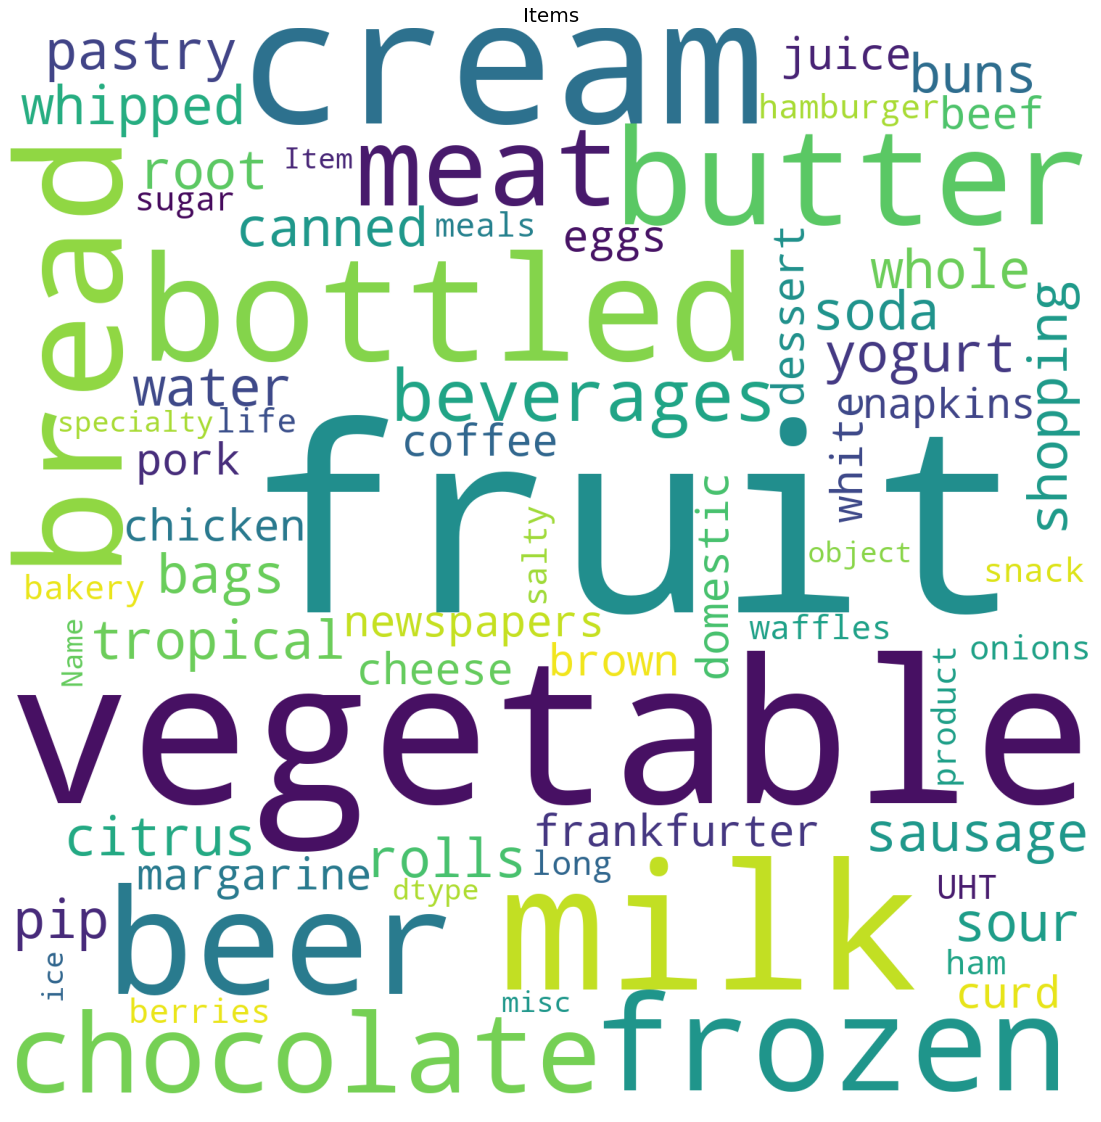

In [37]:
#let's use the worldcloud for visualization 
from wordcloud import WordCloud


plt.rcParams['figure.figsize'] = (20, 20)
wordcloud = WordCloud(background_color = 'white', width = 1500,  height = 1500, max_words = 1000).generate(str(item['Item']))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Items',fontsize = 20)
plt.show()


# **Apriori Algorithm**

In [38]:
#We use this package to performing apriory algorithm analysis
from mlxtend.frequent_patterns import apriori, association_rules

https://towardsdatascience.com/apriori-association-rule-mining-explanation-and-python-implementation-290b42afdfc6

In [39]:
freq_items = apriori(transactions, min_support=0.001, use_colnames=True)
freq_items.head(7)

,support,itemsets
0,0.004010,(Instant food products)
1,0.021386,(UHT-milk)
2,0.001470,(abrasive cleaner)
3,0.001938,(artif. sweetener)
4,0.008087,(baking powder)
5,0.001136,(bathroom cleaner)
6,0.033950,(beef)


In [40]:
freq_items['length'] = freq_items['itemsets'].apply(lambda x: len(x))

In [41]:
freq_items.max()

support     0.157923                     
itemsets    (sausage, yogurt, whole milk)
length      3                            
dtype: object

In [42]:
rules = association_rules(freq_items, metric="confidence", min_threshold=0.001)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(UHT-milk),(bottled water),0.021386,0.060683,0.001069,0.050000,0.823954,-0.000228,0.988755
1,(bottled water),(UHT-milk),0.060683,0.021386,0.001069,0.017621,0.823954,-0.000228,0.996168
2,(UHT-milk),(other vegetables),0.021386,0.122101,0.002139,0.100000,0.818993,-0.000473,0.975443
3,(other vegetables),(UHT-milk),0.122101,0.021386,0.002139,0.017515,0.818993,-0.000473,0.996060
4,(UHT-milk),(rolls/buns),0.021386,0.110005,0.001804,0.084375,0.767013,-0.000548,0.972009


In [43]:
fig=px.scatter(rules['support'], rules['confidence'], color_discrete_sequence=['green'])
fig.update_layout(
    xaxis_title="support",
    yaxis_title="confidence",
    font_family="Helectiva",
    font_color="navy",
    title_font_family="Helectiva",
    title=('Support vs Confidence')
    
)

fig.show()

In [44]:
fig=px.scatter(rules['support'], rules['lift'], color_discrete_sequence=['green'])
fig.update_layout(
    xaxis_title="support",
    yaxis_title="lift",
   
    font_family="Courier New",
    font_color="navy",
    title_font_family="Times New Roman",
    title_font_color="red",
    title=('Support vs Lift')
    
)

fig.show()

Text(0.5, 1.0, 'lift vs Confidence')

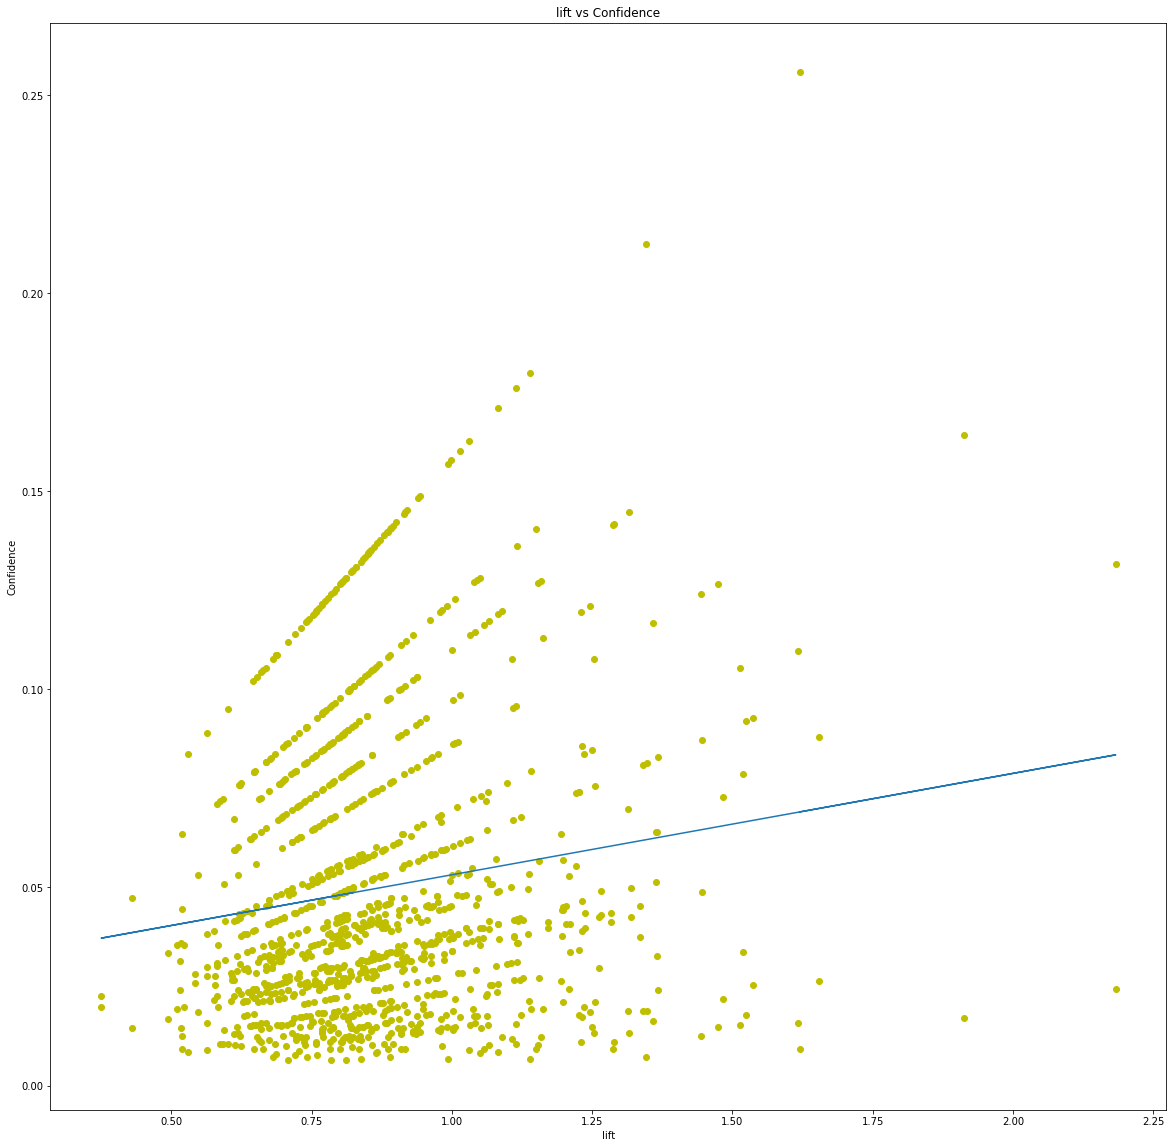

In [45]:
fit = np.polyfit(rules['lift'], rules['confidence'], 1)
fit_fn = np.poly1d(fit)
plt.plot(rules['lift'], rules['confidence'], 'yo', rules['lift'], 
fit_fn(rules['lift']))
plt.xlabel('lift')
plt.ylabel('Confidence')
plt.title('lift vs Confidence')

Text(0.5, 1.0, 'lift vs Confidence')

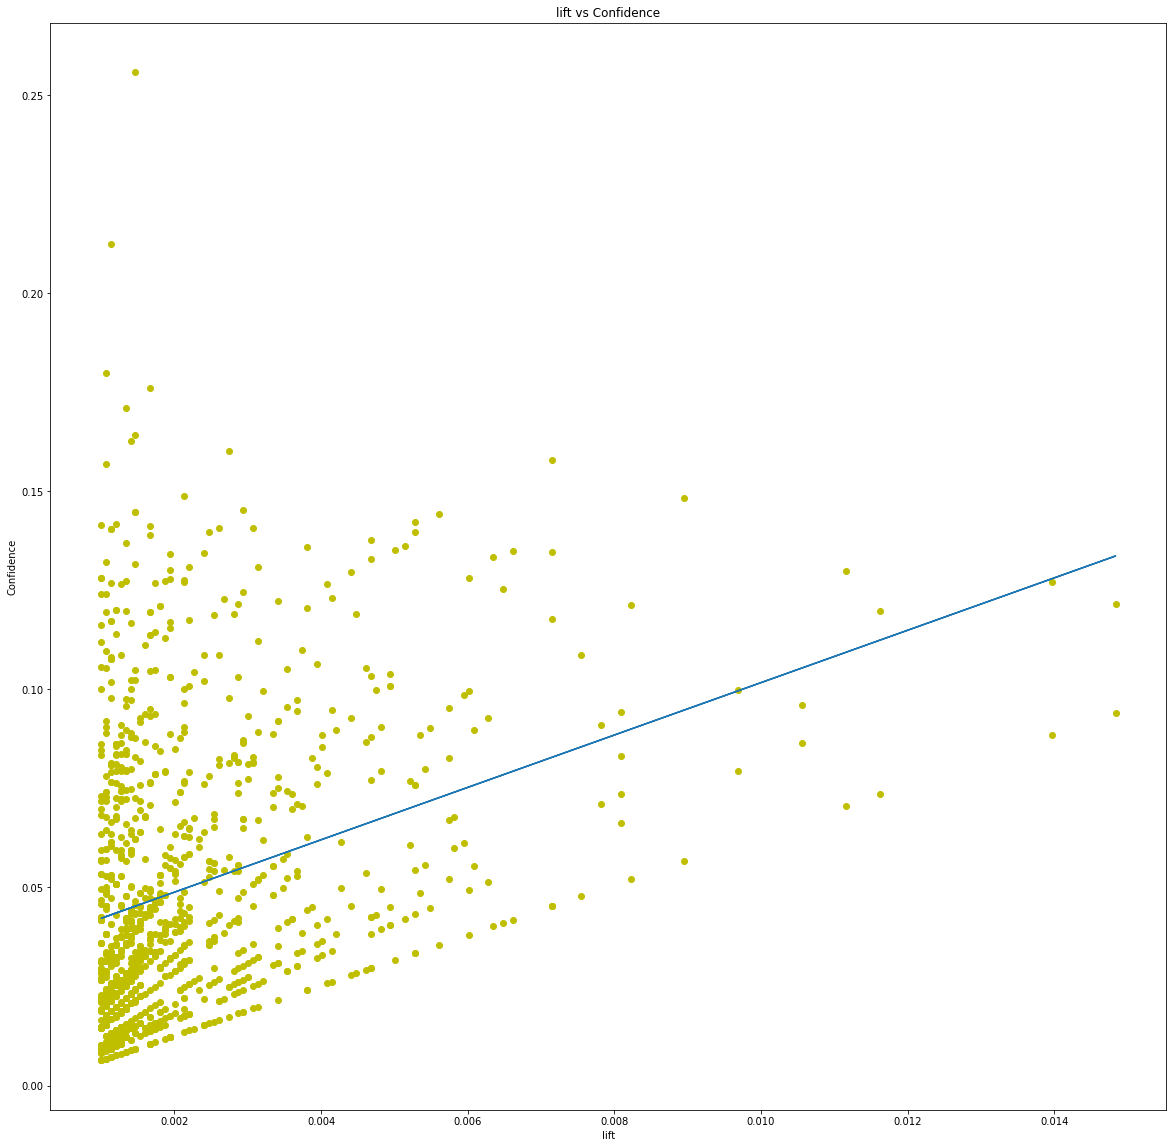

In [46]:
fit = np.polyfit(rules['support'], rules['confidence'], 1)
fit_fn = np.poly1d(fit)
plt.plot(rules['support'], rules['confidence'], 'yo', rules['support'], 
fit_fn(rules['support']))
plt.xlabel('lift')
plt.ylabel('Confidence')
plt.title('lift vs Confidence')

# **Changing Hyperparameter**

In [47]:
rules2 = association_rules(freq_items, metric="confidence", min_threshold=0.05)
rules2.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(UHT-milk),(bottled water),0.021386,0.060683,0.001069,0.050000,0.823954,-0.000228,0.988755
1,(UHT-milk),(other vegetables),0.021386,0.122101,0.002139,0.100000,0.818993,-0.000473,0.975443
2,(UHT-milk),(rolls/buns),0.021386,0.110005,0.001804,0.084375,0.767013,-0.000548,0.972009
3,(UHT-milk),(sausage),0.021386,0.060349,0.001136,0.053125,0.880298,-0.000154,0.992371
4,(UHT-milk),(soda),0.021386,0.097106,0.001270,0.059375,0.611444,-0.000807,0.959887


In [48]:
rules2.count()

antecedents           450
consequents           450
antecedent support    450
consequent support    450
support               450
confidence            450
lift                  450
leverage              450
conviction            450
dtype: int64

In [49]:
fig=px.scatter(rules2['support'], rules2['confidence'], color_discrete_sequence=['green'])
fig.update_layout(
    xaxis_title="support",
    yaxis_title="confidence",
    font_family="Helectiva",
    font_color="navy",
    title_font_family="Helectiva",
    title=('Support vs Confidence')
    
)

fig.show()

In [50]:
fig=px.scatter(rules2['support'], rules2['lift'], color_discrete_sequence=['green'])
fig.update_layout(
    xaxis_title="support",
    yaxis_title="lift",
    font_family="Courier New",
    font_color="navy",
    title_font_family="Times New Roman",
    title_font_color="red",
    title=('Support vs Lift')
    
)

fig.show()

Text(0.5, 1.0, 'lift vs Confidence')

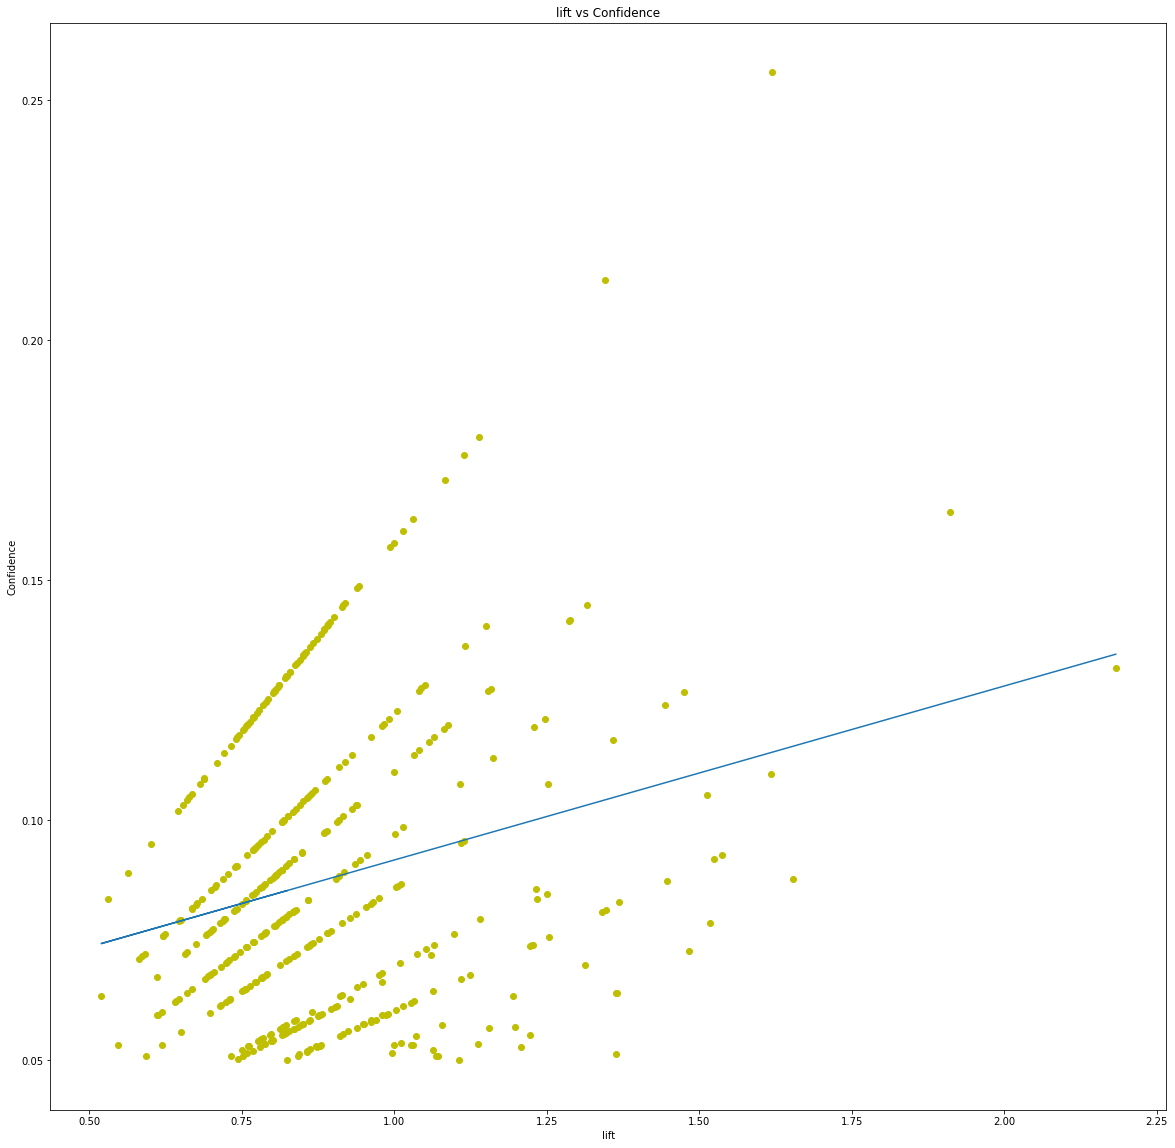

In [51]:
fit = np.polyfit(rules2['lift'], rules2['confidence'], 1)
fit_fn = np.poly1d(fit)
plt.plot(rules2['lift'], rules2['confidence'], 'yo', rules2['lift'], 
fit_fn(rules2['lift']))
plt.xlabel('lift')
plt.ylabel('Confidence')
plt.title('lift vs Confidence')

Text(0.5, 1.0, 'lift vs Confidence')

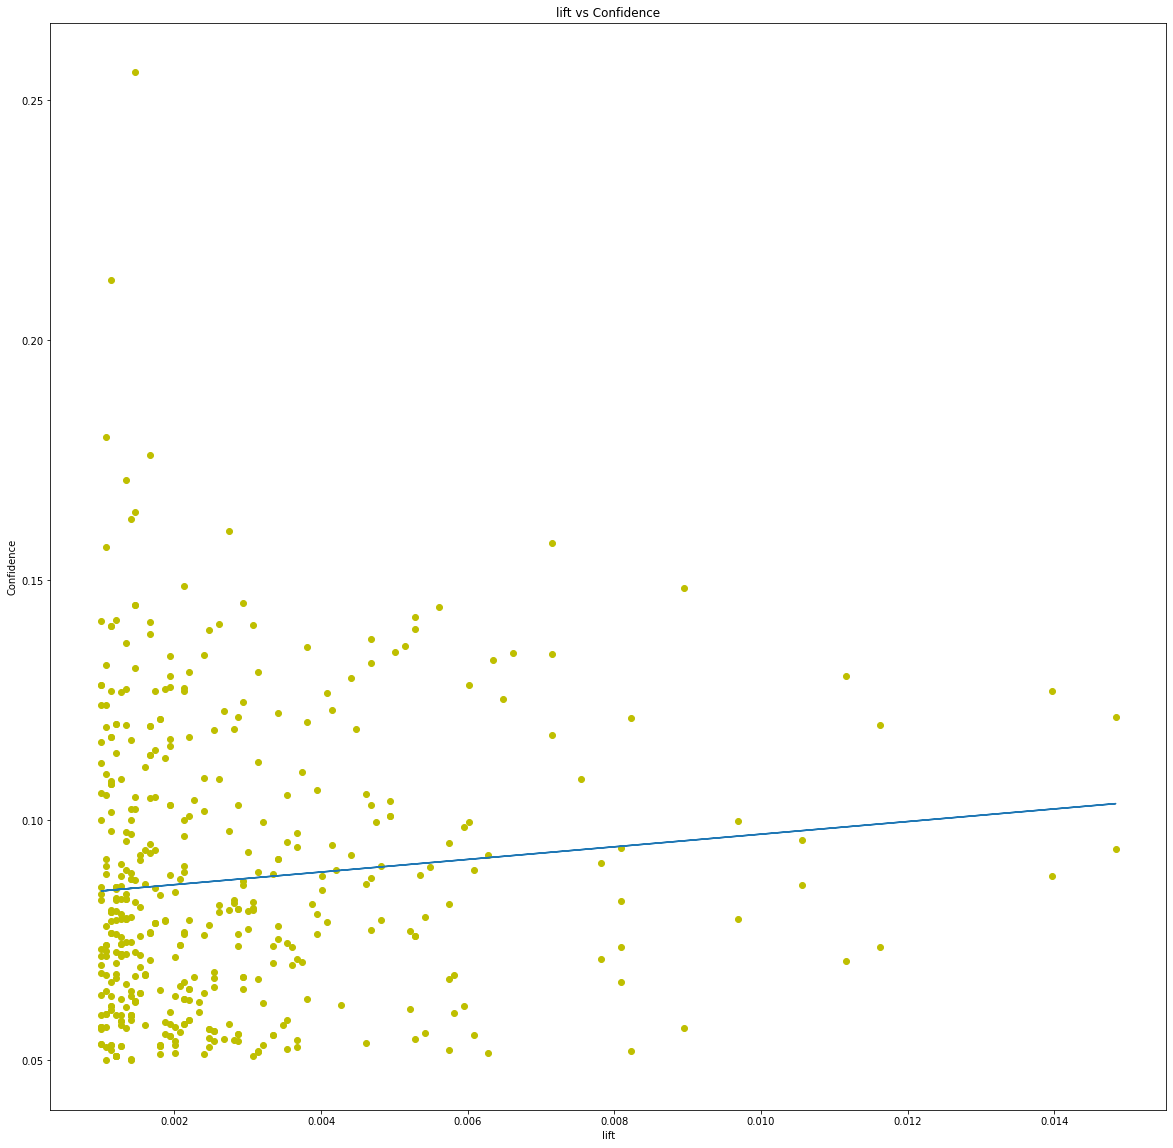

In [52]:
fit = np.polyfit(rules2['support'], rules2['confidence'], 1)
fit_fn = np.poly1d(fit)
plt.plot(rules2['support'], rules2['confidence'], 'yo', rules2['support'], 
fit_fn(rules2['support']))
plt.xlabel('lift')
plt.ylabel('Confidence')
plt.title('lift vs Confidence')

In [53]:
bar_plot(rules2, "support")